Branch - multi_bw_changes

PR - <link>

In [1]:
import sys
sys.path.append("C:/Users/msachde1/Downloads/Research/Development/mgwr")

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from mgwr.gwr import GWR
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
import multiprocessing as mp
pool = mp.Pool()
from scipy import linalg
import numpy.linalg as la
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from spreg.utils import spdot, spmultiply
from scipy import special
import libpysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import copy
from collections import namedtuple
import spglm

### Simulated data for Poisson MGWR

##### Forming variables

In [3]:
def add(a,b):
    return 1+((1/12)*(a+b))

def con(u,v):
    return (0*(u)*(v))+3

def sp(u,v):
    return 1+1/324*(36-(6-u/2)**2)*(36-(6-v/2)**2)

In [4]:
x = np.linspace(0, 25, 25)
y = np.linspace(25, 0, 25)
X, Y = np.meshgrid(x, y)

In [5]:
x1=np.random.normal(0,0.1,625)
x2=np.random.normal(0,0.25,625)

In [6]:
B0=con(X,Y)
B1=add(X,Y)
B2=sp(X,Y)

([], <a list of 0 Text yticklabel objects>)

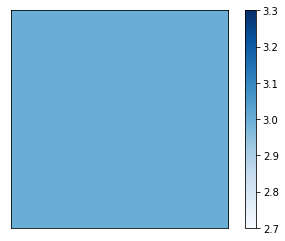

In [7]:
plt.imshow(B0, extent=[0,10, 0, 10], origin='lower',cmap='Blues')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

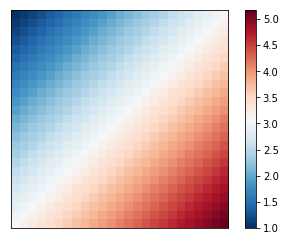

In [8]:
plt.imshow(B1, extent=[0,10, 0, 10], origin='lower',cmap='RdBu_r')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

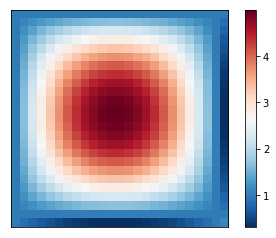

In [9]:
plt.imshow(B2, extent=[0,25, 0, 25], origin='lower',cmap='RdBu_r')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

In [10]:
B0=B0.reshape(-1,1)
B1=B1.reshape(-1,1)
B2=B2.reshape(-1,1)

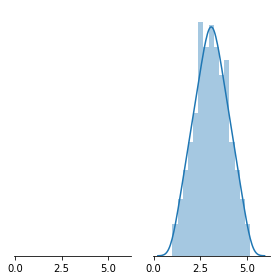

In [11]:
f, axes = plt.subplots(1, 2, figsize=(4, 4), sharex=True)
sns.despine(left=True)
sns.distplot(B0,ax=axes[0])
sns.distplot(B1,ax=axes[1])

plt.setp(axes, yticks=[])
plt.tight_layout()

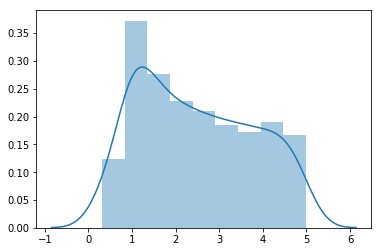

In [12]:
sns.distplot(B2)

In [13]:
lat=Y.reshape(-1,1)
lon=X.reshape(-1,1)

In [14]:
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)

In [15]:
param = np.hstack([B0,B1,B2])
cons=np.ones_like(x1)
X=np.hstack([cons,x1,x2])

In [16]:
X.shape

(625, 3)

In [17]:
#y
y=(np.exp(np.sum(X * param, axis=1).reshape(-1, 1)))

In [18]:
y.shape

(625, 1)

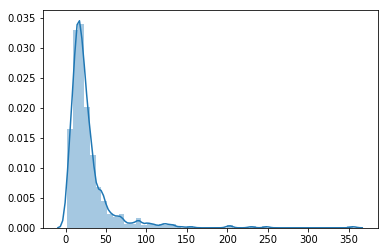

In [19]:
sns.distplot(y)

In [20]:
coords = np.array(list(zip(lon,lat)))
y = np.array(y).reshape((-1,1))

In [21]:
x=x1
x_std = (x-x.mean(axis=0))/x.std(axis=0)
X=np.hstack([x1,x2])
X_std = (X-X.mean(axis=0))/X.std(axis=0)

#### First example: checking GWR and MGWR models with one independent variable and constant = False

In [22]:
bw=Sel_BW(coords,y,x_std,family=Poisson(),offset=None,constant=False)
bw=bw.search()
gwr_model=GWR(coords,y,x_std,bw,family=Poisson(),offset=None,constant=False).fit()

In [23]:
bw

43.0

In [43]:
selector=Sel_BW(coords,y,x_std,multi=True,family=Poisson(),offset=None,constant=False)

In [25]:
selector.search(verbose=True)

Current iteration: 1 ,SOC: 0.0
Bandwidths: 43.0


array([43.])

In [27]:
mgwr_model=MGWR(coords,y,x_std,selector,family=Poisson(),offset=None,constant=False).fit()

##### Parameter check:

In [28]:
np.sum(((gwr_model.params-mgwr_model.params)==0.0)==True)

571

In [29]:
gwr_model.aic,mgwr_model.aic

(73204.30659590986, 73217.19169185885)

In [30]:
np.sum((gwr_model.predy-mgwr_model.predy==0)==True)

580

#### Second example for bandwidths

In [32]:
bw=Sel_BW(coords,y,X_std,family=Poisson(),offset=None)
bw=bw.search()
gwr_model=GWR(coords,y,X_std,bw,family=Poisson(),offset=None).fit()

In [33]:
bw

70.0

In [45]:
selector=Sel_BW(coords,y,X_std,multi=True,family=Poisson(),offset=None)

In [46]:
selector.search(verbose=True)

Current iteration: 1 ,SOC: 0.003981
Bandwidths: 165.0, 49.0, 57.0
Current iteration: 2 ,SOC: 0.0015196
Bandwidths: 204.0, 46.0, 57.0
Current iteration: 3 ,SOC: 0.0002195
Bandwidths: 204.0, 46.0, 57.0
Current iteration: 4 ,SOC: 3.38e-05
Bandwidths: 204.0, 46.0, 57.0
Current iteration: 5 ,SOC: 4.8e-06
Bandwidths: 204.0, 46.0, 57.0


array([204.,  46.,  57.])

In [47]:
mgwr_model=MGWR(coords,y,X_std,selector,family=Poisson(),offset=None).fit()

In [48]:
gwr_model.aic,mgwr_model.aic

(316.31974783179794, 21254.05879125747)

In [49]:
gwr_model.predy-mgwr_model.predy

array([[-5.44214569e+01],
       [-3.38471925e+01],
       [ 4.15164246e+01],
       [ 2.19379090e+01],
       [ 1.78343498e+01],
       [-1.09015240e+02],
       [-1.44533981e+00],
       [ 5.18280948e+00],
       [ 6.62643716e+00],
       [ 3.92227590e+01],
       [-4.16522513e+01],
       [-3.35773504e+00],
       [-2.15891176e+01],
       [ 4.51353446e+01],
       [ 1.65885199e+01],
       [-7.78800613e+01],
       [ 9.34031341e+00],
       [-4.62707610e+00],
       [ 3.51732087e+01],
       [ 5.05693909e+01],
       [-5.01048123e+01],
       [-8.79258294e+01],
       [-4.03892751e+01],
       [-2.91771080e+01],
       [ 3.14790683e+01],
       [ 5.00975890e+01],
       [ 1.31935023e+01],
       [-3.62333980e+01],
       [-1.52132667e+01],
       [-7.42756807e+01],
       [-9.01276878e+00],
       [ 1.59352652e+01],
       [-5.12197284e+00],
       [ 3.69404343e+01],
       [-3.71633638e+01],
       [-1.66893097e+02],
       [ 1.49588775e+01],
       [ 2.72443412e+01],
       [-1.7

Significant differences are seen in the predy, aic, aicc and bic for both

Needs further checking

#### Global model check

In [50]:
import statsmodels.api as sma

In [51]:
X_std_glob=sma.add_constant(X_std)

In [52]:
poisson_mod = sma.Poisson(y, X_std_glob)

In [53]:
poisson_res = poisson_mod.fit(method="newton")
print(poisson_res.summary())

Optimization terminated successfully.
         Current function value: 4.744412
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                  625
Model:                        Poisson   Df Residuals:                      622
Method:                           MLE   Df Model:                            2
Date:                Fri, 21 Jun 2019   Pseudo R-squ.:                  0.6175
Time:                        19:49:02   Log-Likelihood:                -2965.3
converged:                       True   LL-Null:                       -7752.3
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0720      0.009    330.550      0.000       3.054       3.090
x1             0.2750      0.

In [54]:
selector=Sel_BW(coords,y,X_std,multi=True,family=Poisson(),offset=None)

In [55]:
selector.search(verbose=True,multi_bw_min=[625,625,625], multi_bw_max=[625,625,625])

Current iteration: 1 ,SOC: 0.0012239
Bandwidths: 625.0, 625.0, 625.0
Current iteration: 2 ,SOC: 0.000105
Bandwidths: 625.0, 625.0, 625.0
Current iteration: 3 ,SOC: 6.8e-06
Bandwidths: 625.0, 625.0, 625.0


array([625., 625., 625.])

In [56]:
mgwr_model=MGWR(coords,y,X_std,selector,family=Poisson(),offset=None).fit()

In [57]:
mgwr_model.params[:5]

array([[3.01771774, 0.39543531, 0.47211797],
       [3.01809359, 0.39971599, 0.47763267],
       [3.01848253, 0.4041978 , 0.48303999],
       [3.01888405, 0.40888618, 0.48827806],
       [3.01929719, 0.41378459, 0.49326914]])

##### parameters similar for global Poisson model and forced global MGWR Poisson model